Dataset

In [1]:
import requests

url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"
response = requests.get(url)

if response.status_code == 200:
    with open("data/housing.csv", "wb") as file:
        file.write(response.content)
else:
    print("Failed to download the file.")

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').

#### EDA
- Load the data.
- Look at the median_house_value variable. Does it have a long tail?

In [2]:
import pandas as pd 

# Load the dataset
df = pd.read_csv("data/housing.csv")

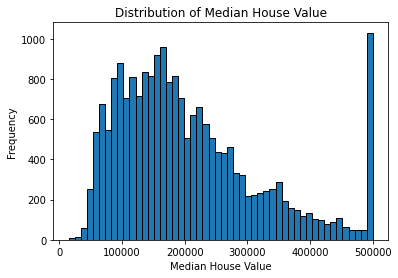

In [3]:
import matplotlib.pyplot as plt

# Plot a histogram of the median_house_value variable
plt.hist(df["median_house_value"], bins=50, edgecolor='k')
plt.xlabel("Median House Value")
plt.ylabel("Frequency")
plt.title("Distribution of Median House Value")
plt.show()

##### Preparing the dataset
For this homework, we only want to use a subset of data.

First, keep only the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`

Next, use only the following columns:

- `'latitude'`,
- `'longitude'`,
- `'housing_median_age'`,
- `'total_rooms'`,
- `'total_bedrooms'`,
- `'population'`,
- `'households'`,
- `'median_income'`,
- `'median_house_value'`

In [4]:
# Filter records where ocean_proximity is either '<1H OCEAN' or 'INLAND'
filtered_df = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]

# Select the desired columns
selected_columns = [
    'latitude',
    'longitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'median_house_value'
]

df = filtered_df[selected_columns]

Question 1

There's one feature with missing values. What is it?

In [5]:
# Check for missing values and sum them up for each column
missing_values = df.isnull().sum()

# Print the columns with missing values
print(missing_values[missing_values > 0])

total_bedrooms    157
dtype: int64


Question 2

What's the median (50% percentile) for variable `'population'`?

In [6]:
# Calculate the median for the 'population' variable
median_population = df['population'].median()

print("Median population:", median_population)

Median population: 1195.0


##### Prepare and split the dataset
- Shuffle the initial dataset, use seed `42`.
- Split your data in train/val/test sets, with 60%/20%/20% distribution.
- Apply the log transformation to the `median_house_value` variable using the `np.log1p()` function.

In [7]:
# Function to preprocess the data
def preprocess_data(df):
    # Apply log transformation to median_house_value
    df['median_house_value'] = np.log1p(df['median_house_value'])
    
    # Separate features and labels
    X = df.drop(columns=['median_house_value'])
    y = df['median_house_value']
    
    return X, y

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

# Shuffle the dataset with seed 42
shuffled_df = df.sample(frac=1, random_state=42)

# Split the dataset into train (60%), validation (20%), and test (20%) sets
train_size = 0.6
val_size = 0.2
test_size = 0.2

train_df, temp_df = train_test_split(shuffled_df, train_size=train_size, random_state=42)
val_df, test_df = train_test_split(temp_df, train_size=val_size/(val_size + test_size), random_state=42)

# Preprocess the data
X_train, y_train = preprocess_data(train_df)
X_val, y_val = preprocess_data(val_df)
X_test, y_test = preprocess_data(test_df)

# Display the shapes of the resulting datasets
print("Train set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Train set shape: (9412, 8)
Validation set shape: (3137, 8)
Test set shape: (3138, 8)


Question 3

1. We need to deal with missing values for the column from Q1.
2. We have two options: fill it with 0 or with the mean of this variable.
3. Try both options. For each, train a linear regression model without regularization using the code from the lessons.
4. For computing the mean, use the training only!
5. Use the validation dataset to evaluate the models and compare the RMSE of each option.
6. Round the RMSE scores to 2 decimal digits using round(score, 2)
7. Which option gives better RMSE?

Options:

- With 0
- With mean
- Both are equally good

In [9]:
# Function to train and evaluate a linear regression model
def train_and_evaluate(X_train, y_train, X_val, y_val):
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Make predictions on the validation dataset
    predictions = model.predict(X_val)
    
    # Calculate RMSE on the validation dataset
    rmse = np.round(np.sqrt(mean_squared_error(y_val, predictions)), 2)
    
    return rmse

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Option 1: Fill missing values with 0
train_df_fill_zero = train_df.fillna(0)
val_df_fill_zero = val_df.fillna(0)

# Option 2: Fill missing values with mean (calculated from training data)
mean_total_bedrooms = train_df['total_bedrooms'].mean()
train_df_fill_mean = train_df.fillna(mean_total_bedrooms)
val_df_fill_mean = val_df.fillna(mean_total_bedrooms)

# Train and evaluate models for both options
X_train_zero, y_train_zero = train_df_fill_zero.drop('median_house_value', axis=1), train_df_fill_zero['median_house_value']
X_val_zero, y_val_zero = val_df_fill_zero.drop('median_house_value', axis=1), val_df_fill_zero['median_house_value']

X_train_mean, y_train_mean = train_df_fill_mean.drop('median_house_value', axis=1), train_df_fill_mean['median_house_value']
X_val_mean, y_val_mean = val_df_fill_mean.drop('median_house_value', axis=1), val_df_fill_mean['median_house_value']

rmse_zero = train_and_evaluate(X_train_zero, y_train_zero, X_val_zero, y_val_zero)

rmse_mean = train_and_evaluate(X_train_mean, y_train_mean, X_val_mean, y_val_mean)

# Compare RMSE scores and print the result
if rmse_zero < rmse_mean:
    print("RMSE with 0:", rmse_zero)
    print("Option: With 0")
elif rmse_zero > rmse_mean:
    print("RMSE with mean:", rmse_mean)
    print("Option: With mean")
else:
    print("Both options are equally good")

print("RMSE With 0:", rmse_zero)
print("RMSE With mean:", rmse_zero)

Both options are equally good
RMSE With 0: 0.35
RMSE With mean: 0.35


Question 4

1. Now let's train a regularized linear regression.
2. For this question, fill the NAs with 0.
3. Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].
4. Use RMSE to evaluate the model on the validation dataset.
5. Round the RMSE scores to 2 decimal digits.
6. Which r gives the best RMSE?

If there are multiple options, select the smallest `r`.

Options:
- 0
- 0.000001
- 0.001
- 0.0001

In [11]:
# Function to train and evaluate a Ridge regression model
def train_and_evaluate_ridge(X_train, y_train, X_val, y_val, r):
    model = Ridge(alpha=r)
    model.fit(X_train, y_train)
    
    w_0 = model.intercept_
    predictions = model.predict(X_val)
    rmse_val = np.round(np.sqrt(mean_squared_error(y_val, predictions)), 2)
    
    return rmse_val, w_0

In [12]:
from sklearn.linear_model import Ridge

# Fill missing values with 0
X_train_fill_zero, y_train_fill_zero = train_df_fill_zero.drop('median_house_value', axis=1), train_df_fill_zero['median_house_value']
X_val_fill_zero, y_val_fill_zero = val_df_fill_zero.drop('median_house_value', axis=1), val_df_fill_zero['median_house_value']

# List of regularization parameter values
r_values = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

# Initialize variables to keep track of the best RMSE and corresponding r value
best_rmse = float('inf')
best_r = None

# Iterate through different r values
for r in r_values:
    rmse_val, w_0 = train_and_evaluate_ridge(X_train_fill_zero, y_train_fill_zero, X_val_fill_zero, y_val_fill_zero, r)
    
    print(f"r={r}, w_0={w_0}, RMSE={rmse_val}")

    # Update best RMSE and corresponding r value if needed
    if rmse_val < best_rmse:
        best_rmse = rmse_val
        best_r = r

# Print the best r value and its corresponding RMSE rounded to 2 decimal places
print(f"The best regularization parameter is r={best_r} with RMSE={round(best_rmse, 2)}")

r=0, w_0=-9.809920225225603, RMSE=0.35
r=1e-06, w_0=-9.80992021484419, RMSE=0.35
r=0.0001, w_0=-9.809919187079988, RMSE=0.35
r=0.001, w_0=-9.809909843773493, RMSE=0.35
r=0.01, w_0=-9.809816411129642, RMSE=0.35
r=0.1, w_0=-9.808882126788113, RMSE=0.35
r=1, w_0=-9.799543491133647, RMSE=0.35
r=5, w_0=-9.758130792318763, RMSE=0.35
r=10, w_0=-9.706575978815579, RMSE=0.35
The best regularization parameter is r=0 with RMSE=0.35


Question 5

1. We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
2. Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
3. For each seed, do the train/validation/test split with 60%/20%/20% distribution.
4. Fill the missing values with 0 and train a model without regularization.
5. For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
6. What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
7. Round the result to 3 decimal digits (round(std, 3))

What's the value of std?

- 0.5
- 0.05
- 0.005
- 0.0005

Note: Standard deviation shows how different the values are. If it's low, then all values are approximately the same. If it's high, the values are different. If standard deviation of scores is low, then our model is stable.

In [13]:
# List of seed values
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Initialize an empty list to store RMSE scores
rmse_scores = []

# Iterate through different seed values
for seed in seed_values:
    # Shuffle the dataset with seed 42
    shuffled_df = df.sample(frac=1, random_state=seed)

    # Split the dataset into train (60%), validation (20%), and test (20%) sets
    train_size = 0.6
    val_size = 0.2
    test_size = 0.2

    train_df, temp_df = train_test_split(shuffled_df, train_size=train_size, random_state=42)
    val_df, test_df = train_test_split(temp_df, train_size=val_size/(val_size + test_size), random_state=42)

    # Fill missing values with 0
    train_df_fill_zero = train_df.fillna(0)
    val_df_fill_zero = val_df.fillna(0)

    # Preprocess the data
    train_X, train_y = preprocess_data(train_df_fill_zero)
    val_X, val_y = preprocess_data(val_df_fill_zero)

    rmse = train_and_evaluate(train_X, train_y, val_X, val_y)

    # Append the RMSE score to the list
    rmse_scores.append(rmse)
    
    # Print r, w_0, and RMSE for the current seed
    print(f"Seed={seed}, RMSE={rmse}")

# Find the minimum standard deviation of RMSE
std_rmse = np.round(np.std(rmse_scores), 3)

# Print the minimum standard deviation
print(f"The minimum standard deviation of RMSE is {std_rmse}")

Seed=0, RMSE=0.34
Seed=1, RMSE=0.33
Seed=2, RMSE=0.35
Seed=3, RMSE=0.33
Seed=4, RMSE=0.34
Seed=5, RMSE=0.34
Seed=6, RMSE=0.34
Seed=7, RMSE=0.34
Seed=8, RMSE=0.35
Seed=9, RMSE=0.34
The minimum standard deviation of RMSE is 0.006


Question 6

1. Split the dataset like previously, use seed 9.
2. Combine train and validation datasets.
3. Fill the missing values with 0 and train a model with r=0.001.
4. What's the RMSE on the test dataset?

Options:
- 0.13
- 0.23
- 0.33
- 0.43

In [14]:
# Seed for shuffling the dataset
seed = 9

# Shuffle the dataset with seed 9
shuffled_df = df.sample(frac=1, random_state=seed)

# Split the dataset into train (60%), validation (20%), and test (20%) sets
train_size = 0.6
val_size = 0.2
test_size = 0.2

train_df, temp_df = train_test_split(shuffled_df, train_size=train_size, random_state=seed)
val_df, test_df = train_test_split(temp_df, train_size=val_size/(val_size + test_size), random_state=seed)

# Combine train and validation datasets
train_val_df = pd.concat([train_df, val_df])

# Fill missing values with 0
train_val_df_fill_zero = train_val_df.fillna(0)
test_df_fill_zero = test_df.fillna(0)

# Preprocess the data
train_X, train_y = preprocess_data(train_val_df_fill_zero)
test_X, test_y = preprocess_data(test_df_fill_zero)

rmse_test, w_0 = train_and_evaluate_ridge(train_X, train_y, test_X, test_y, r = 0.001)

# Print the RMSE on the test dataset
print("RMSE on the test dataset:", rmse_test)

RMSE on the test dataset: 0.33
